In [1]:
%cd /proj/azizpour-group/users/x_amime/projects/an_explanation_model

from source.project_manager import load_experiment_metadata
from source.data_manager import imagenet_loader_from_metadata
from source.model_manager import init_resnet50_forward, forward_with_projection
import argparse
import jax
import tensorflow as tf
import jax.numpy as jnp
import os
from glob import glob
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from functools import partial
from PIL import Image

/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/proj/azizpour-group/users/x_amime/projects/an_explanation_model


2024-03-09 10:12:53.297556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 10:12:53.297655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 10:12:53.299563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 10:12:53.329034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 10:12:56.028777: W tensorflow/compiler/tf2

In [3]:
x = np.linspace(0, 3, 100)
a = np.array([.10, .15, .2])
f = lambda x,a: x*x*np.exp(-8*np.pi*np.pi*a*a*x*x)
y = np.array([f(x, a_i) for a_i in a])

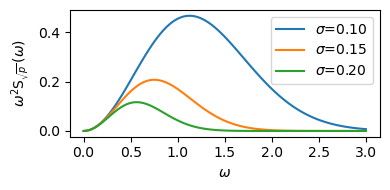

In [4]:
u=4
fig,ax = plt.subplots(1, 1, figsize=(u, u/2))
for i in range(len(a)):
    ax.plot(x, y[i], label=r'$\sigma$'+f'={a[i]:.2f}')
ax.legend()

ax.set_ylabel(r'$\omega^2\operatorname{S}_{\sqrt{p}}(\omega)$')
# ax.set_yticks([])
ax.set_xlabel(r'$\omega$')
plt.tight_layout()

plt.savefig('outputs/figures/bands.pdf')

[]

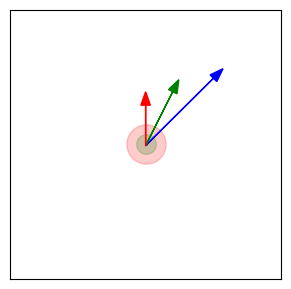

In [234]:
# from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches


def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
    p = mpatches.FancyArrow(
        0, 0.5 * height, width, 0, length_includes_head=True, head_width=0.75 * height
    )
    return p


u = 3.5
fig, ax = plt.subplots(1, 1, figsize=(u, u))
ax.scatter(0, 0, c="r", s=800, alpha=0.2)
ax.scatter(0, 0, c="g", s=200, alpha=0.2)
s1 = ax.scatter(0, 0, c="b", s=1)
s3 = ax.scatter(5, 5, c="r", s=100, alpha=0.2)
s2 = ax.scatter(5, 5, c="g", s=50, alpha=0.2)

a1 = ax.arrow(
    0,
    0 - 0.01,
    0.5,
    0.5,
    head_width=0.07,
    head_length=0.1,
    fc="b",
    ec="b",
)
a2 = ax.arrow(
    0,
    0 - 0.01,
    0.2,
    0.4,
    head_width=0.07,
    head_length=0.1,
    fc="g",
    ec="g",
)
a3 = ax.arrow(
    0,
    0 - 0.01,
    0,
    0.3,
    head_width=0.07,
    head_length=0.1,
    fc="r",
    ec="r",
)
# ax.legend(
#     [a1, a2, a3, s1, s2, s3],
#     [
#         r"$\nabla$ at $\sigma = 0.0$",
#         r"$\nabla$ at $\sigma = 0.3$",
#         r"$\nabla$ at $\sigma = 0.6$",
#         r"$\sigma = 0.0$",
#         r"$\sigma = 0.3$",
#         r"$\sigma = 0.6$",
#     ],
#     handler_map={
#         mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow),
#     },
# )
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([])

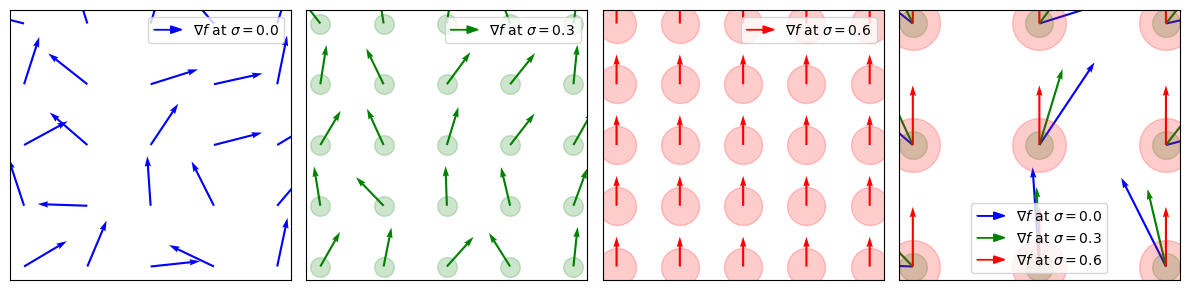

In [269]:
u = 3
fig, axes = plt.subplots(1, 4, figsize=(4 * u, u))

for ax in axes:
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])

# vector field
N = 5
x = np.linspace(-0.9, 0.9, N)
y = np.linspace(-0.9, 0.9, N)
X, Y = np.meshgrid(x, y)
s_n = 3
s1 = 1
s2 = 0.5
scale = 8

# random rotations
theta = np.random.uniform(-90, 90, size=(N, N))

V1 = 1
U1 = 1
V2 = 0.8
U2 = 0.8
V3 = 0.6
U3 = 0.6

axes[0].quiver(X, Y, U1, V1, angles=90 + theta, color="b", scale=scale)
axes[1].quiver(X, Y, U2, V2, angles=90 + theta * 0.5, color="g", scale=scale)
axes[2].quiver(X, Y, U3, V3, angles=90, color="r", scale=scale)
axes[1].scatter(X, Y, c="g",alpha=0.2, s=200)
axes[2].scatter(X, Y, c="r",alpha=0.2, s=750)

axes[3].quiver(X, Y, U1, V1, angles=90 + theta, color="b", scale=scale/2)
axes[3].quiver(X, Y, U2, V2, angles=90 + theta * 0.5, color="g", scale=scale/2)
axes[3].quiver(X, Y, U3, V3, angles=90, color="r", scale=scale/2)
axes[3].scatter(X, Y, c="g",alpha=0.2, s=2*200)
axes[3].scatter(X, Y, c="r",alpha=0.2, s=2*750)

a2 = axes[2].arrow(
    5,
    5,
    10,
    10,
    head_width=0.07,
    head_length=0.1,
    fc="r",
    ec="r",
)
a1 = axes[1].arrow(
    5,
    5,
    10,
    10,
    head_width=0.07,
    head_length=0.1,
    fc="g",
    ec="g",
)
a0 = axes[0].arrow(
    5,
    5,
    10,
    10,
    head_width=0.07,
    head_length=0.1,
    fc="b",
    ec="b",
)
axes[2].legend(
    [a2],
    [
        r"$\nabla f$ at $\sigma = 0.6$",
    ],
    handler_map={
        mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow),
    },
)
axes[1].legend(
    [a1],
    [
        r"$\nabla f$ at $\sigma = 0.3$",
    ],
    handler_map={
        mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow),
    },
)
axes[0].legend(
    [a0],
    [
        r"$\nabla f$ at $\sigma = 0.0$",
    ],
    handler_map={
        mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow),
    },
)
ax = axes[3]


a1 = ax.arrow(
    10,
    10,
    10,
    10,
    head_width=0.07,
    head_length=0.1,
    fc="b",
    ec="b",
)
a2 = ax.arrow(
    10,
    10,
    10,
    10,
    head_width=0.07,
    head_length=0.1,
    fc="g",
    ec="g",
)
a3 = ax.arrow(
    10,
    10,
    10,
    10,
    head_width=0.07,
    head_length=0.1,
    fc="r",
    ec="r",
)
ax.legend(
    [
        a1,
        a2,
        a3,
    ],
    [
        r"$\nabla f$ at $\sigma = 0.0$",
        r"$\nabla f$ at $\sigma = 0.3$",
        r"$\nabla f$ at $\sigma = 0.6$",
    ],
    handler_map={
        mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow),
    },
)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig('outputs/figures/vector_space_nablaf.pdf')

In [2]:
save_metadata_dir = "outputs/metadata/8_2_convex_1/"
paths = os.path.join(save_metadata_dir, "merged_metadata.csv")
paths = glob(paths)
data = []
for path in paths:
    project_metadata = pd.read_csv(path)
    ids =(project_metadata.stream_name == "vanilla_grad_mask") & (project_metadata.stream_statistic == "meanx2")
    project_metadata = project_metadata[ids]
    data.append(project_metadata.copy())

project_metadata = pd.concat(data)

In [3]:
def compute_normalized_similarity(row):
    alpha = row["alpha_mask_value"]
    data_path = row["data_path"]
    if os.path.exists(data_path):
        data = np.load(data_path)
        return data.sum() * (alpha**(2.5))
    else:
        return -1


temp = project_metadata[["alpha_mask_value", "data_path"]]
temp = temp.apply(compute_normalized_similarity, axis=1)
temp = pd.concat([temp,project_metadata[["alpha_mask_value", "image_index"]]], axis=1)
temp.rename(columns={0: "similarity"}, inplace=True)
temp.to_csv("outputs/processed/8/KC_similarity.csv", index=False)

In [6]:
temp = pd.read_csv("outputs/processed/7/KC_convex_similarity.csv")
temp = temp.drop(columns="image_index")

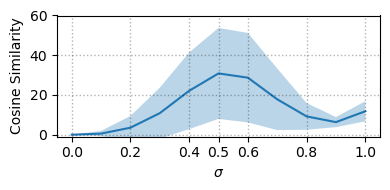

In [10]:
u=4
fig, ax = plt.subplots(1,1,figsize=(u, u/2))
# plot mean with error bands
means = temp.groupby("alpha_mask_value").mean()
stds = temp.groupby("alpha_mask_value").std()
ax.plot(means.index, means.similarity, label="mean")
ax.fill_between(
    means.index,
    means.similarity - stds.similarity,
    means.similarity + stds.similarity,
    alpha=0.3,
)
plt.xlabel(r"$\sigma$")
plt.ylabel(
    "Cosine Similarity"
)
# draw lines
xticks = ax.get_xticks()
xticks = list(xticks) 
xticks.append(0.5)
ax.set_xticks(xticks)
for data in xticks:
    plt.axvline(data, linestyle=":", color="black", alpha=0.3, linewidth=1)
yticks = plt.yticks()[0]
for y in yticks:
    plt.axhline(y, linestyle=":", color="black", alpha=0.3, linewidth=1)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-1, 60)
# make figure square
plt.tight_layout()

plt.savefig("outputs/figures/band_similarity_imagenet.pdf", bbox_inches="tight")

In [ ]:
from source.data_manager import minmax_normalize


norm_similarity_image = np.zeros((224, 224, 3))
def compute_normalized_similarity_image(row):
    global norm_similarity_image
    alpha = row["alpha_mask_value"]
    data_path = row["data_path"]
    if os.path.exists(data_path):
        data = np.load(data_path)
        norm_similarity_image = (data * (alpha**(2.5)))/temp.shape[0] + norm_similarity_image
        return 0
    else:
        return -1


temp = project_metadata[["alpha_mask_value", "data_path"]]
temp = temp[project_metadata.image_index == 0]
print(temp.shape)
temp.apply(compute_normalized_similarity_image, axis=1)

np.save("outputs/processed/norm_similarity_image.npy",norm_similarity_image)
plt.imshow(minmax_normalize(norm_similarity_image), cmap="hot")
# this shows that most of the images are object centered!

In [ ]:
n_rows = 1
n_cols = 3
scale = 2
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * scale, n_rows * scale / 2),
    sharey=True,
    sharex=True,
)
for i, ax in enumerate(axes):
    ax.set_xlabel("Perturbation Scale")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    # frame off
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_ylabel("Output")

axes[2].plot([1, 0], [0, 0.5], color="blue")
axes[2].plot([0, 0], [0, 0.5], color="blue")
axes[2].plot([1, 0], [0, 0], color="blue")

axes[2].plot([1, 0], [0.5, 1], color="red")
axes[2].plot([0, 0], [0.5, 1], color="red")
axes[2].plot([1, 1], [0, 0.5], color="red")

axes[2].text(0.5, 0.5, "noise", ha="center", va="center")
axes[2].text(0.25, 0.15, "signal", ha="center", va="center")

axes[2].fill_between(
    [0, 1], [0.5, 0], [1, 0.5], color="pink", alpha=0.2, edgecolor="red", hatch="|"
)
axes[2].fill_between(
    [0, 1], [0, 0], [0.5, 0], color="lightblue", alpha=0.2, edgecolor="blue", hatch="+"
)

axes[1].plot([1, 0], [0, 1], color="blue")
axes[1].plot([0, 0], [0, 1], color="blue")
axes[1].plot([1, 0], [0, 0], color="blue")

axes[1].plot([1, 0], [1, 1], color="red")
axes[1].plot([1, 1], [0, 1], color="red")

axes[1].text(0.75, 0.75, "noise", ha="center", va="center")
axes[1].text(0.25, 0.25, "signal", ha="center", va="center")

axes[1].fill_between(
    [0, 1], [1, 0], [1, 1], color="pink", alpha=0.2, edgecolor="red", hatch="|"
)
axes[1].fill_between(
    [0, 1], [0, 0], [1, 0], color="lightblue", alpha=0.2, edgecolor="blue", hatch="+"
)
198

axes[0].plot([1, 0], [0.5, 0.5], color="blue")
axes[0].plot([0, 0], [0, 0.5], color="blue")
axes[0].plot([1, 0], [0, 0], color="blue")
axes[0].plot([1, 1], [0, 0.5], color="blue")

axes[0].plot([0, 1], [0.5, 1], color="red")
axes[0].plot([1, 1], [0.5, 1], color="red")

axes[0].text(0.75, 0.65, "noise", ha="center", va="center")
axes[0].text(0.5, 0.25, "signal", ha="center", va="center")

axes[0].fill_between(
    [0, 1], [0.5, 0.5], [0.5, 1], color="pink", alpha=0.2, edgecolor="red", hatch="|"
)
axes[0].fill_between(
    [0, 1],
    [0, 0],
    [0.5, 0.5],
    facecolor="lightblue",
    alpha=0.2,
    edgecolor="blue",
    hatch="+",
)

plt.show()
fig.savefig("outputs/figures/combination_fns.pdf", bbox_inches="tight")

In [41]:
ind = [7, 8]
dataset = ["imagenet", "food101"]
kind = ["zero", "gaussian"]
x_ = [(0, 1.1), (0, 1), (0, 1.1), (0, 3.5)]
y_ = [(0.5, 7), (0, 5), (0.5, 4), (0.0, 4)]
c_ = [1, 0.3, 1, 0.4]

fig, axes = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
i = 0
for ind_, dataset_ in zip(ind, dataset):
    for kind_ in kind:
        entropy = pd.read_csv(
            f"outputs/processed/{ind_}/predictive_entropy_{kind_}_{dataset_}.csv"
        )
        axes[i].plot(
            entropy.alpha_mask_value,
            entropy.data_path,
            label=f"{kind_.capitalize()} {dataset_.capitalize()}",
        )
        axes[i].axvline(x=c_[i], color="r", linestyle="--", label="Critical Value")
        axes[i].set_ylim(*y_[i])
        axes[i].set_xlim(*x_[i])
        ys = axes[i].get_yticks()
        xs = axes[i].get_xticks()
        for x in xs:
            axes[i].axvline(x, color="k", alpha=0.1, linestyle=":")
        for y in ys:
            axes[i].axhline(y, color="k", alpha=0.1, linestyle=":")
        axes[i].set_ylabel("Predictive Entropy")
        axes[i].set_xlabel(r"Perturbation Scale $\sigma$")
        axes[i].legend()
        i += 1
plt.savefig(f"outputs/figures/predictive_entropies.pdf", bbox_inches="tight")